<a href="https://colab.research.google.com/github/PratikshitSingh/digit-dataset-representation-with-t-sne/blob/main/t_sne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install gensim==3.6.0
!pip install numpy==1.19.5
!pip install matplotlib==3.2.2
!pip install scikit-learn==0.21.3
!pip install nltk==3.2.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.8 MB 5.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.8.2+zzzcolab20220929150707 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
jaxlib 0.3.20+cuda11.cudnn805 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
jax 0.3.21 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
cmdstanpy 1.0.7 requires numpy>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 5.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.21.3 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.21.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.2 MB/s 
  Created wheel for nltk: filename=nltk-3.2.5-py3-none-any.whl size=1392155 sha256=323289c39d682df4744a4cb713a4cb6e61f9a84a6b7c55fd266f580e35e889b0
  Stored in directory: /root/.cache/pip/wheels/60/de/57/6bced01d340818a36413222e6efcc7766d1f1e4575782b6223
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [1]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

In [2]:
X, y = load_digits(return_X_y=True)

In [3]:
MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30

In [4]:
def fit(X):
    n_samples = X.shape[0]
    
    # Compute euclidean distance
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    # Compute joint probabilities p_ij from distances.
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    
    # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
    # degrees_of_freedom = n_components - 1 comes from
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

In [7]:
def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
  params = X_embedded.ravel() #flatten the array
    
  obj_func = _kl_divergence
    
  params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
        
  X_embedded = params.reshape(n_samples, n_components) #changing back to 2D
  return X_embedded

In [8]:
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
  X_embedded = params.reshape(n_samples, n_components)
    
  dist = pdist(X_embedded, "sqeuclidean")
  dist /= degrees_of_freedom
  dist += 1.
  dist **= (degrees_of_freedom + 1.0) / -2.0
  Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)

  # Kullback-Leibler divergence of P and Q
  kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))

  # Gradient: dC/dY
  grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
  PQd = squareform((P - Q) * dist)
  for i in range(n_samples):
    grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                        X_embedded[i] - X_embedded)
  grad = grad.ravel()
  c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
  grad *= c
  return kl_divergence, grad

In [9]:
def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    
  p = p0.copy().ravel()
  update = np.zeros_like(p)
  gains = np.ones_like(p)
  error = np.finfo(np.float).max
  best_error = np.finfo(np.float).max
  best_iter = i = it
    
  for i in range(it, n_iter):
    error, grad = obj_func(p, *args)
    grad_norm = linalg.norm(grad)
    inc = update * grad < 0.0
    dec = np.invert(inc)
    gains[inc] += 0.2
    gains[dec] *= 0.8
    np.clip(gains, min_gain, np.inf, out=gains)
    grad *= gains
    update = momentum * update - learning_rate * grad
    p += update
    print("[t-SNE] Iteration %d: error = %.7f,"
                    " gradient norm = %.7f"
                    % (i + 1, error, grad_norm))
      
    if error < best_error:
      best_error = error
      best_iter = i
    elif i - best_iter > n_iter_without_progress:
      break
    
    if grad_norm <= min_grad_norm:
      break
  return p

In [10]:
X_embedded = fit(X)

[t-SNE] Iteration 1: error = 4.0229677, gradient norm = 0.0000051
[t-SNE] Iteration 2: error = 4.0229676, gradient norm = 0.0000051
[t-SNE] Iteration 3: error = 4.0229676, gradient norm = 0.0000064
[t-SNE] Iteration 4: error = 4.0229676, gradient norm = 0.0000101
[t-SNE] Iteration 5: error = 4.0229676, gradient norm = 0.0000177
[t-SNE] Iteration 6: error = 4.0229673, gradient norm = 0.0000332
[t-SNE] Iteration 7: error = 4.0229664, gradient norm = 0.0000664
[t-SNE] Iteration 8: error = 4.0229622, gradient norm = 0.0001409
[t-SNE] Iteration 9: error = 4.0229413, gradient norm = 0.0003151
[t-SNE] Iteration 10: error = 4.0228259, gradient norm = 0.0007390
[t-SNE] Iteration 11: error = 4.0221325, gradient norm = 0.0018051
[t-SNE] Iteration 12: error = 4.0176739, gradient norm = 0.0044931
[t-SNE] Iteration 13: error = 3.9895563, gradient norm = 0.0103135
[t-SNE] Iteration 14: error = 3.8588225, gradient norm = 0.0172731
[t-SNE] Iteration 15: error = 3.5409790, gradient norm = 0.0185908
[t-S

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


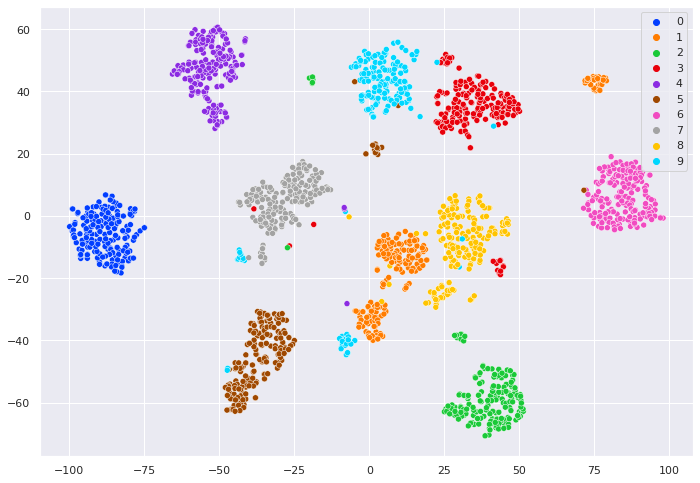

In [11]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)